# Gesture Recognition with CNN

This notebook demonstrates training a CNN on a subset of the HaGRID dataset and using it to classify new gesture images, plotting and saving a confusion matrix.

In [1]:
import cv2
import json
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomContrast
from keras.metrics import categorical_crossentropy
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Configuration
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)
COLOR_CHANNELS = 3
PATH = '../gesture_dataset_sample'
CONDITIONS = ['like', 'dislike', 'stop', 'peace', 'rock']

In [2]:
# Helper function to preprocess images

def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

In [3]:
# Load training data and annotations
images = []
labels = []
label_names = []

for condition in CONDITIONS:
    with open(f'{PATH}/_annotations/{condition}.json') as f:
        annotations = json.load(f)
    for filename in os.listdir(f'{PATH}/{condition}'):
        UID = filename.split('.')[0]
        img = cv2.imread(f'{PATH}/{condition}/{filename}')
        if img is None or UID not in annotations:
            continue
        annotation = annotations[UID]
        for i, bbox in enumerate(annotation['bboxes']):
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            label = annotation['labels'][i]
            if label not in label_names:
                label_names.append(label)
            label_index = label_names.index(label)
            images.append(preprocessed)
            labels.append(label_index)

In [4]:
# Prepare data for training
X = np.array(images).astype('float32') / 255.
y = np.array(labels)
X = X.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
y_one_hot = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

In [5]:
# Build and train the CNN model
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'leaky_relu'
layer_count = 2
num_neurons = 64

model = Sequential()
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))
model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))
model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.2))
model.add(Flatten())
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))
model.add(Dense(num_neurons, activation=activation))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50


d:\Projects\Uni\ITT\assignment-05-cnn-realdegrees-1\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2053 - loss: 1.8060 - val_accuracy: 0.1534 - val_loss: 1.8124 - learning_rate: 0.0010
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2537 - loss: 1.7584 - val_accuracy: 0.3129 - val_loss: 1.6138 - learning_rate: 0.0010
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3891 - loss: 1.5559 - val_accuracy: 0.5092 - val_loss: 1.2056 - learning_rate: 0.0010
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6062 - loss: 1.1346 - val_accuracy: 0.6442 - val_loss: 0.9132 - learning_rate: 0.0010
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7396 - loss: 0.7744 - val_accuracy: 0.7791 - val_loss: 0.6219 - learning_rate: 0.0010
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8007 - loss: 0.5460 - val_accuracy: 0.8681 - val_loss: 0.3741 - learning_rate: 0.0010
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8747 - loss: 0.4011 - val_

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


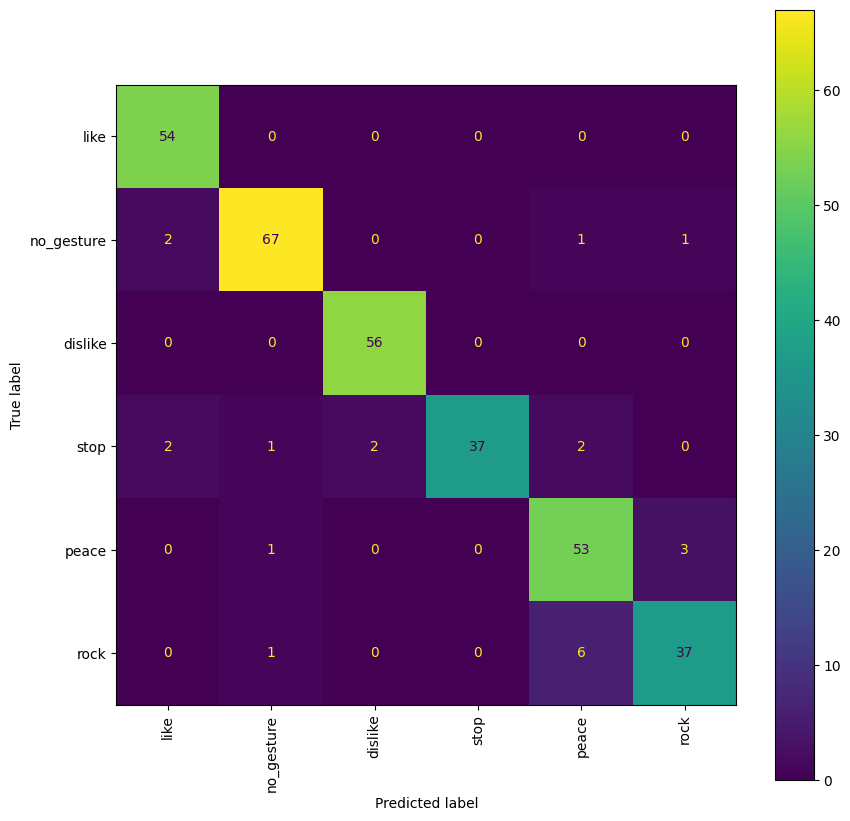

In [6]:
# Evaluate and plot confusion matrix on test set
y_test_labels = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test), axis=1)
conf_matrix = confusion_matrix(y_test_labels, y_pred)
fig = plt.figure(figsize=(10, 10))
ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())
plt.xticks(rotation=90, ha='center')
plt.show()